# Assignment 4
## Load and plot results

In [11]:
# Import libs
import os
from random import uniform
import logging
import traceback
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from playground import ColorizedLogger

In [27]:
# Set the options
text_color = 'lightgrey'
# text_color = 'black'
RUNS_TO_PLOT = ['run_non_parallel_1', 
                'run_parallel_1',
                'run_parallel_2', 
                'run_parallel_4',
                'run_parallel_8']

In [30]:
# Configure
logger = ColorizedLogger('Plotter', 'yellow')
sys_path = os.path.dirname(os.path.abspath(''))
output_base_path = os.path.join(sys_path, 'outputs', 'final', 'assignment4')

In [31]:
# Find the saved run results
all_runs = [d for d in glob(os.path.join(output_base_path, "run*"))
            if os.path.isdir(d)]
if len(all_runs) > 0:
    all_runs = [d.split(os.sep)[-1] for d in all_runs]
else:
    raise Exception("No runs found!")
runs_diff = set(RUNS_TO_PLOT).difference(all_runs)
if len(runs_diff) > 0:
    logger.info(f"Skipping some runs that are not available: {runs_diff}")
runs = [os.path.join(output_base_path, run) 
        for run in set(RUNS_TO_PLOT).intersection(all_runs)]

In [32]:
# Gather the results
results = []
for run in runs:
    run_results = []
    run_results.append(np.load(file=os.path.join(run, "metadata.npy"), 
                               allow_pickle=True).item())
    run_results.append(np.load(file=os.path.join(run, "train_epoch_accuracies.npy"),
                                     allow_pickle=True))
    run_results.append(np.load(file=os.path.join(run, "train_epoch_losses.npy"),
                                 allow_pickle=True))
    run_results.append(None)
    run_results.append(np.load(file=os.path.join(run, "train_epoch_times.npy"),
                                allow_pickle=True))
    run_results.append(np.load(file=os.path.join(run, "test_results_after.npy"),
                                 allow_pickle=True).item())
    test_results_before_path = os.path.join(run, "test_results_before.npy")
    if os.path.exists(test_results_before_path): # Because this is optional
        run_results.append(np.load(file=test_results_before_path, 
                                   allow_pickle=True).item())
    run_results.append(run)
    
    results.append(run_results)

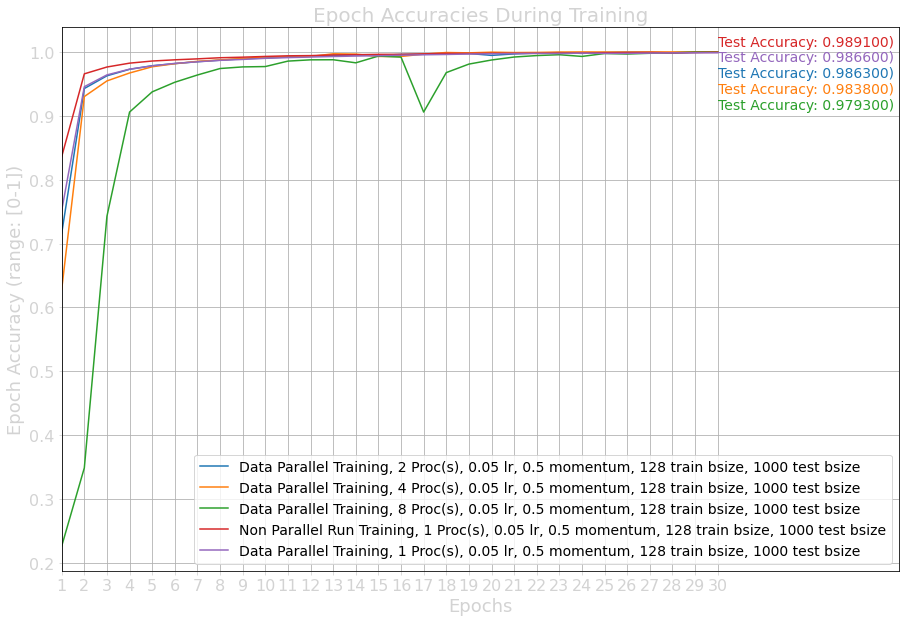

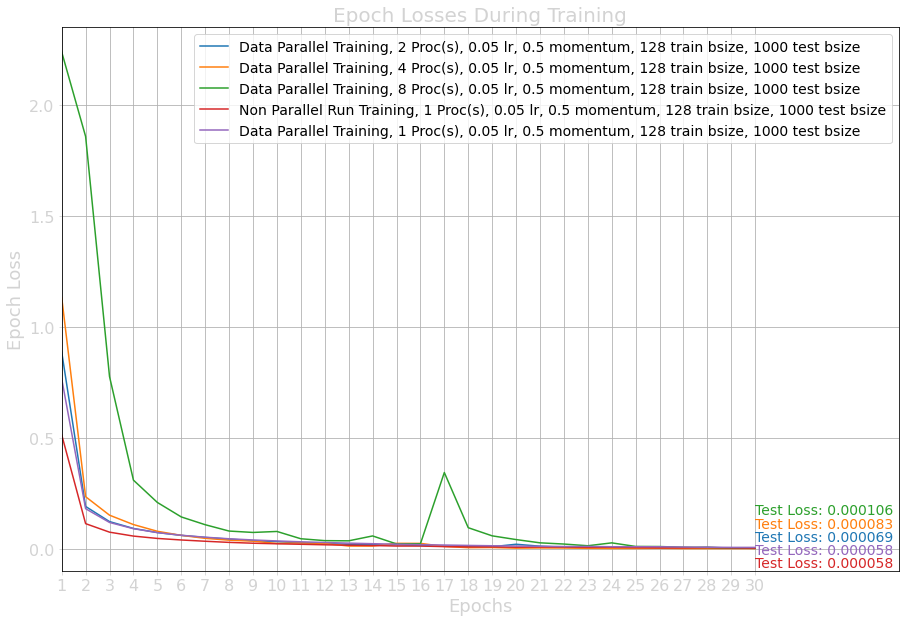

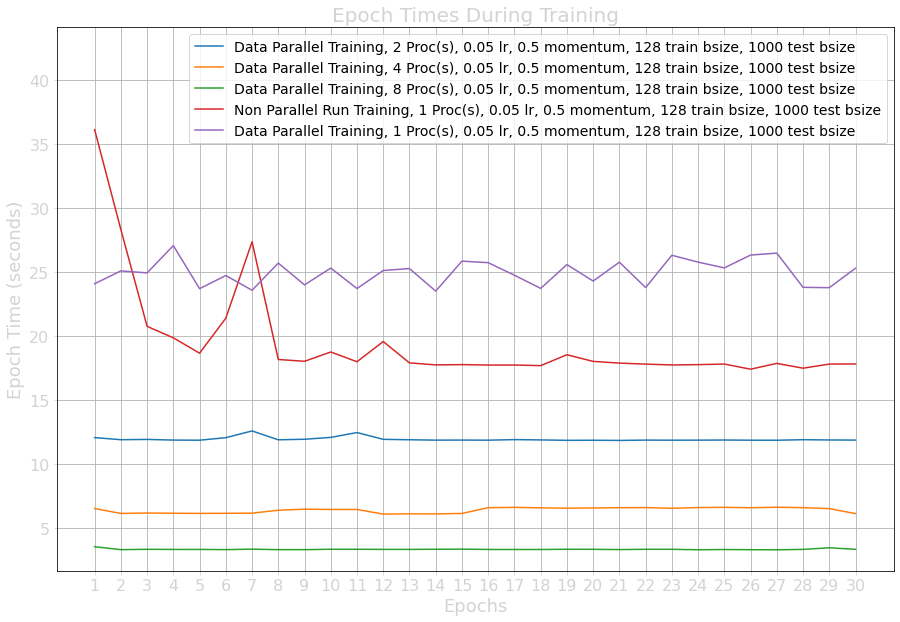

<Figure size 432x288 with 0 Axes>

In [45]:
# Plot them
def plot_accuracies(results):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
    ax.set_title('Epoch Accuracies During Training', fontsize=20, c=text_color)
    ax.set_xlabel('Epochs', fontsize=18, c=text_color)
    ax.set_ylabel('Epoch Accuracy (range: [0-1])', fontsize=18, c=text_color)
    max_epoch = results[0][0]["epochs"]+1
    epochs = range(1, max_epoch)
    ax.set_xticks(epochs)    
    ax.tick_params(axis="both", labelsize=16, colors=text_color)
    ax.grid()
    max_y = 0.0
    annot_data = []
    for result in results:
        mdata = result[0]
        y_vals = result[1]
        test_results = result[5]        
        run_type = "Data Parallel Training" if mdata['data_parallel'] \
                                            else "Non Parallel Run Training"
        legend_label = f"{run_type}, {mdata['num_processes']} Proc(s), " \
                       f"{mdata['learning_rate']} lr, " \
                       f"{mdata['momentum']} momentum, " \
                       f"{mdata['batch_size_train']} train bsize, " \
                       f"{mdata['batch_size_test']} test bsize"

        line = ax.plot(epochs, y_vals, label=legend_label)
        ax.legend(loc="lower right", fontsize=14)
        # Prepare Annotations
        curr_max_y = np.amax(y_vals)
        if curr_max_y > max_y:
            max_y = curr_max_y
        annotated_text = f"Test Accuracy: {test_results['percent_correct']:5f})"
        annot_data.append((annotated_text,
                         mdata["epochs"],
                         y_vals[-1],
                         line[0].get_color()))
    for ind, curr_annot in enumerate(sorted(annot_data, key=lambda x: x[0], reverse=True)):
        ax.annotate(curr_annot[0], 
                    xy=(curr_annot[1], max_y-ind*0.025+0.01),
                    color=curr_annot[3],
                    size=14)
        
    ax.set_xlim(1, max_epoch+7)
    for result in results:
        fig.savefig(os.path.join(result[-1], 'accuracies.png'), dpi=fig.dpi)

def plot_losses(results):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
    ax.set_title('Epoch Losses During Training', fontsize=20, c=text_color)
    ax.set_xlabel('Epochs', fontsize=18, c=text_color)
    ax.set_ylabel('Epoch Loss', fontsize=18, c=text_color)
    max_epoch = results[0][0]["epochs"]+1
    epochs = range(1, max_epoch)
    ax.set_xticks(epochs)    
    ax.tick_params(axis="both", labelsize=16, colors=text_color)
    ax.grid()
    min_y = float('inf')
    annot_data = []
    for result in results:
        mdata = result[0]
        y_vals = result[2]
        test_results = result[5]        
        run_type = "Data Parallel Training" if mdata['data_parallel'] \
                                            else "Non Parallel Run Training"
        legend_label = f"{run_type}, {mdata['num_processes']} Proc(s), " \
                       f"{mdata['learning_rate']} lr, " \
                       f"{mdata['momentum']} momentum, " \
                       f"{mdata['batch_size_train']} train bsize, " \
                       f"{mdata['batch_size_test']} test bsize"
        line = ax.plot(epochs, y_vals, label=legend_label)
        ax.legend(loc="upper right", fontsize=14)
        # Prepare Annotations
        curr_min_y = np.amin(y_vals)
        if curr_min_y < min_y:
            min_y = curr_min_y
        annotated_text = f"Test Loss: {test_results['test_loss']:5f}"
        annot_data.append((annotated_text,
                         mdata["epochs"],
                         y_vals[-1],
                         line[0].get_color()))
            
    for ind, curr_annot in enumerate(sorted(annot_data, key=lambda x: x[0])):
        ax.annotate(curr_annot[0], 
                    xy=(curr_annot[1], -0.085+min_y+ind*0.06),
                    color=curr_annot[3],
                    size=14)
    ax.set_xlim(1, max_epoch+5)
    ax.set_ylim(bottom=min_y-0.1)
    for result in results:
        fig.savefig(os.path.join(result[-1], 'losses.png'), dpi=fig.dpi)

def plot_times(results):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
    ax.set_title('Epoch Times During Training', fontsize=20, c=text_color)
    ax.set_xlabel('Epochs', fontsize=18, c=text_color)
    ax.set_ylabel('Epoch Time (seconds)', fontsize=18, c=text_color)
    max_epoch = results[0][0]["epochs"]+1
    epochs = range(1, max_epoch)
    ax.set_xticks(epochs)    
    ax.tick_params(axis="both", labelsize=16, colors=text_color)
    ax.grid()
    max_y = 0.0
    for result in results:
        mdata = result[0]
        y_vals = result[4]
        test_results = result[5]
        run_type = "Data Parallel Training" if mdata['data_parallel'] \
                                            else "Non Parallel Run Training"
        legend_label = f"{run_type}, {mdata['num_processes']} Proc(s), " \
                       f"{mdata['learning_rate']} lr, " \
                       f"{mdata['momentum']} momentum, " \
                       f"{mdata['batch_size_train']} train bsize, " \
                       f"{mdata['batch_size_test']} test bsize"
        lines = ax.plot(epochs, y_vals, label=legend_label)
        ax.legend(loc="upper right", fontsize=14)
        curr_max_y = np.amax(y_vals)
        if curr_max_y > max_y:
            max_y = curr_max_y
    ax.set_ylim(top=max_y+8)
    for result in results:
        fig.savefig(os.path.join(result[-1], 'times.png'), dpi=fig.dpi)

plot_accuracies(results)
plot_losses(results)
plot_times(results)
        
plt.show()
plt.clf()